# Okavango_Scenario

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import matplotlib.patches as patches
from matplotlib.dates import date2num
import matplotlib.dates as mdates
from hydroeval import evaluator, nse, rmse, pbias
from pyemu.pst.pst_utils import SFMT,IFMT,FFMT

flopy is installed in C:\Users\seonggyu.park\Miniconda3\envs\sm_pest\lib\site-packages\flopy


# Set Path

In [5]:
wd_scn = "D:/Projects/Watersheds/Okavango/scenarios/okvg_swatmf_scn_bau_new"
wd_base = "D:/Projects/Watersheds/Okavango/scenarios/okvg_swatmf_calibrated_base_new"
wd_rd = "D:/Projects/Watersheds/Okavango/scenarios/okvg_swatmf_scn_rd_new"
# os.chdir(wd)



# Create Dataframe from output.rch

## BAU

In [6]:
ress = [48]
scn_137 = pd.read_csv(
                    os.path.join(wd_scn, "output.rsv"),
                    delim_whitespace=True,
                    skiprows=9,
                    # usecols=[1, 2, 5], # streamflow
                    usecols=[1, 2, 10], # sediment
                    names=["res_no", "filter", "scn_137"],
                    index_col=0)
scn_137 = scn_137.loc[48]
scn_137 = scn_137[scn_137["filter"] < 13]
scn_137.index = pd.date_range('1/1/2003', periods=len(scn_137.scn_137), freq="M")

scn_240 = pd.read_csv(
                    os.path.join(wd_scn, "output.rch"),
                    delim_whitespace=True,
                    skiprows=9,
                    # usecols=[1, 3, 6], # streamflow
                    usecols=[1, 3, 10], # streamflow
                    names=["date", "filter", "scn_240"],
                    index_col=0)
scn_240 = scn_240.loc[240]
scn_240 = scn_240[scn_240["filter"] < 13]
scn_240.index = pd.date_range('1/1/2003', periods=len(scn_240.scn_240), freq="M")


In [7]:
scn_137

,filter,scn_137
2003-01-31,1,2073.000
2003-02-28,2,1215.000
2003-03-31,3,2035.000
2003-04-30,4,3484.000
2003-05-31,5,1229.000
...,...,...
2019-08-31,8,0.000
2019-09-30,9,0.000
2019-10-31,10,0.000
2019-11-30,11,0.000


In [8]:
scn_240

,filter,scn_240
2003-01-31,1.0,108600.0
2003-02-28,2.0,136900.0
2003-03-31,3.0,136300.0
2003-04-30,4.0,165100.0
2003-05-31,5.0,182000.0
...,...,...
2019-08-31,8.0,23290.0
2019-09-30,9.0,17050.0
2019-10-31,10.0,15160.0
2019-11-30,11.0,19050.0


In [9]:
scn_df = pd.concat([scn_137, scn_240], axis=1)
scn_dff = scn_df.groupby(scn_df.index.month).mean()
# scn_df_aa = scn_df.resample('A').mean()
# scn_df_as = scn_df.resample('A').sum() * 86400
scn_dff = scn_dff.drop('filter', axis=1)
scn_dff

,scn_137,scn_240
1,1284.547059,90955.882353
2,992.629412,123794.117647
3,1772.523529,151752.352941
4,1992.547059,169072.352941
5,707.796471,133324.117647
6,532.259176,58930.000000
7,614.023324,47647.647059
8,704.158824,38374.705882
9,798.364706,28324.705882
10,956.700000,27513.529412


## BASE

In [10]:
# Select subs
subs = [137, 240]

# Create data with parameter change
df_rch = pd.read_csv(
                    os.path.join(wd_base, "output.rch"),
                    delim_whitespace=True,
                    skiprows=9,
                    # usecols=[1, 3, 6], # streamflow
                    usecols=[1, 3, 10], # sed
                    names=["date", "filter", "streamflow_sim"],
                    index_col=0)
df_adj = pd.DataFrame()
for i in subs:
    df = df_rch.loc[i]
    df = df[df["filter"] < 13]
    df.index = pd.date_range('1/1/2003', periods=len(df.streamflow_sim), freq="M")
    df.rename(columns = {'streamflow_sim':'base_{}'.format(i)}, inplace = True)
    # df = df.drop('filter', axis=1)
    df_adj = pd.concat(
        [df_adj, df['base_{}'.format(i)]], axis=1,
        sort=False
        )
df_adj.index = pd.DatetimeIndex(df_adj.index).normalize()



In [11]:
df_adj

,base_137,base_240
2003-01-31,18010.000000,109400.0
2003-02-28,67260.000000,190100.0
2003-03-31,14240.000000,242100.0
2003-04-30,52380.000000,193400.0
2003-05-31,3564.000000,188100.0
...,...,...
2019-08-31,0.000436,26310.0
2019-09-30,0.000179,19270.0
2019-10-31,0.019360,16220.0
2019-11-30,0.017500,23040.0


In [12]:
base_df = df_adj.groupby(df_adj.index.month).mean()
base_df.index
base_df

,base_137,base_240
1,98121.705882,99024.117647
2,259014.941176,173373.529412
3,178884.117647,223931.176471
4,45859.352941,218431.764706
5,2816.229412,148628.235294
6,111.601176,62048.823529
7,5.653385,42958.235294
8,0.006536,34323.529412
9,0.000183,27099.411765
10,0.013586,26542.941176


# RD

In [13]:
# Select subs
subs = [137, 240]

# Create data with parameter change
df_rch = pd.read_csv(
                    os.path.join(wd_rd, "output.rch"),
                    delim_whitespace=True,
                    skiprows=9,
                    # usecols=[1, 3, 6], # streamflow
                    usecols=[1, 3, 10], # sed
                    names=["date", "filter", "streamflow_sim"],
                    index_col=0)
df_rd = pd.DataFrame()
for i in subs:
    df = df_rch.loc[i]
    df = df[df['filter'] < 13]
    df.index = pd.date_range('1/1/2003', periods=len(df.streamflow_sim), freq="M")
    
    df.rename(columns = {'streamflow_sim':'base_{}'.format(i)}, inplace = True)
    df_rd = pd.concat(
        [df_rd, df['base_{}'.format(i)]], axis=1,
        sort=False
        )
df_rd.index = pd.DatetimeIndex(df_rd.index).normalize()
rd_df = df_rd
df_rd = df_rd.groupby(df_rd.index.month).mean()
df_rd



,base_137,base_240
1,103085.352941,97515.882353
2,266277.058824,172698.235294
3,189367.647059,223205.882353
4,54459.235294,217582.352941
5,3851.852941,145515.882353
6,337.147059,59228.823529
7,213.382353,41063.529412
8,174.094118,33200.000000
9,249.082353,26082.352941
10,300.088235,25095.294118


# Average Monthly Streamflow

In [15]:
from matplotlib.ticker import FuncFormatter
sys.path.insert(0, 'D:/spark-brc_gits/swatmf_git/swatmf_pkgs')
from swatmf_viz import y_fmt

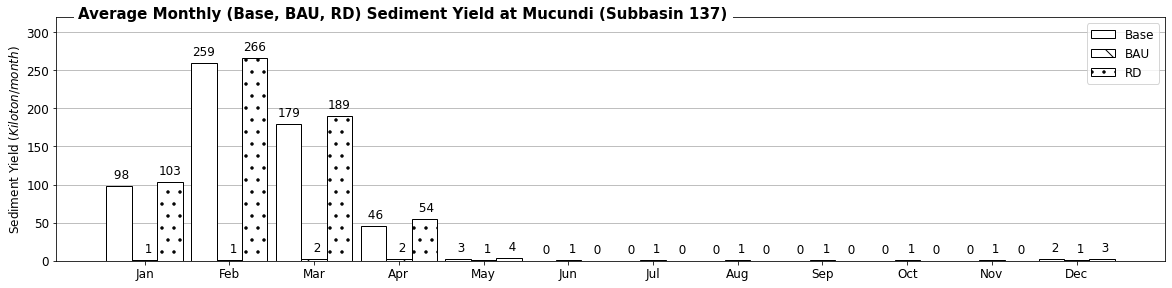

In [16]:
fig, ax = plt.subplots( 
                # sharex=True,
                figsize=(16,4)
                )
# x = date2num(base_df.index)
w = 0.3
ax.bar(base_df.index-0.3, base_df.base_137, width=w, align='center', label='Base', hatch='', color='white', edgecolor='black', zorder=3)
ax.bar(base_df.index, scn_dff.scn_137, width=w, align='center', label='BAU', hatch='\\', color='white', edgecolor='black', zorder=3)
ax.bar(base_df.index+0.3, df_rd.base_137, width=w, align='center', label='RD', hatch='.', color='white', edgecolor='black', zorder=3)

for index, value in zip(base_df.index-0.2, base_df.base_137):
    ax.text(
        index-0.1, value+10000, '{:3.0f}'.format(value/1000),
        fontsize=12, rotation=0, horizontalalignment='center')
for index, value in zip(base_df.index, scn_dff.scn_137):
    ax.text(index, value+10000, '{:3.0f}'.format(value/1000), fontsize=12, rotation=0, horizontalalignment='center')
for index, value in zip(base_df.index, df_rd.base_137):
    ax.text(index+0.3, value+10000, '{:3.0f}'.format(value/1000), fontsize=12, rotation=0, horizontalalignment='center')


ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))


ax.tick_params(axis='both', labelsize=12)
# plt.setp(ax.get_xticklabels(), rotation=70)
# ax.set_xticks(base_df.index[::1])
# ax.xaxis_date()
# plt.xticks[1].set_visible(False)
ax.set_xticks(base_df.index[::1])
month_names = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_xticklabels(month_names)
ax.margins(y=0.2)
ax.set_title(
    # 'Average Monthly (Base, BAU, RD) Streamflow at Mucundi (Subbasin 137)', # streamflow
    'Average Monthly (Base, BAU, RD) Sediment Yield at Mucundi (Subbasin 137)', #sed
    fontsize=15,
    fontweight="bold",
    horizontalalignment='left',
    x=0.02,
    y=0.97,
    bbox=dict(
        facecolor='white',
        edgecolor='white'))
# ax.autoscale(tight=True)
plt.tight_layout()
ax.legend(fontsize=12)
ax.grid(axis='y', zorder=0)
ax.set_ylabel(r'Sediment Yield $(Kiloton/month)$', fontsize = 12)
plt.savefig('am_mucundi_ff_sed.png', dpi=300, bbox_inches="tight")
plt.show()

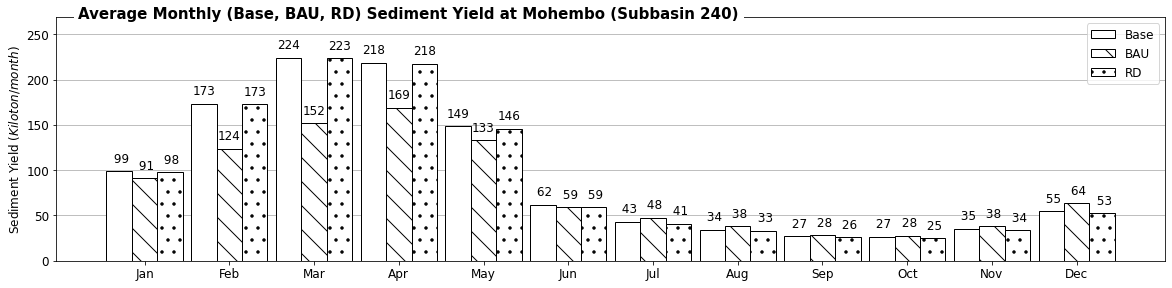

In [17]:
fig, ax = plt.subplots( 
                # sharex=True,
                figsize=(16,4)
                )
# x = date2num(base_df.index)
w = 0.3
ax.bar(base_df.index-0.3, base_df.base_240, width=w, align='center', label='Base', hatch='', color='white', edgecolor='black', zorder=3)
ax.bar(base_df.index, scn_dff.scn_240, width=w, align='center', label='BAU', hatch='\\', color='white', edgecolor='black', zorder=3)
ax.bar(base_df.index+0.3, df_rd.base_240, width=w, align='center', label='RD', hatch='.', color='white', edgecolor='black', zorder=3)

for index, value in zip(base_df.index-0.2, base_df.base_240):
    ax.text(
        index-0.1, value+10000, '{:3.0f}'.format(value/1000),
        fontsize=12, rotation=0, horizontalalignment='center')
for index, value in zip(base_df.index, scn_dff.scn_240):
    ax.text(index, value+10000, '{:3.0f}'.format(value/1000), fontsize=12, rotation=0, horizontalalignment='center')
for index, value in zip(base_df.index, df_rd.base_240):
    ax.text(index+0.3, value+10000, '{:3.0f}'.format(value/1000), fontsize=12, rotation=0, horizontalalignment='center')

ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))

ax.tick_params(axis='both', labelsize=12)
# plt.setp(ax.get_xticklabels(), rotation=70)
# ax.set_xticks(base_df.index[::1])
# ax.xaxis_date()
# plt.xticks[1].set_visible(False)
ax.set_xticks(base_df.index[::1])
month_names = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_xticklabels(month_names)


ax.margins(y=0.2)
ax.set_title(
    'Average Monthly (Base, BAU, RD) Sediment Yield at Mohembo (Subbasin 240)',
    fontsize=15,
    fontweight="bold",
    horizontalalignment='left',
    x=0.02,
    y=0.97,
    bbox=dict(
        facecolor='white',
        edgecolor='white'))
# ax.autoscale(tight=True)
plt.tight_layout()
ax.legend(fontsize=12)
ax.grid(axis='y', zorder=0)
# ax.set_ylabel(r'Stream Discharge $[m^3/s]$', fontsize = 12)
ax.set_ylabel(r'Sediment Yield $(Kiloton/month)$', fontsize = 12)
plt.savefig('am_mohembo_ff_sed.png', dpi=300, bbox_inches="tight")
plt.show()

# Average Annual Stream/Sediment

In [24]:
asbau_df

scn_137     12687.922912
scn_240    971635.294118
dtype: float64

In [25]:
bau_df = pd.concat([scn_137, scn_240], axis=1)
bau_df = bau_df.drop('filter', axis=1)
asbau_df = bau_df.resample('A').sum().mean()
asbau_df = asbau_df/(1e6)

In [26]:
asrd_df = rd_df.resample('A').sum().mean()
asrd_df = asrd_df/(1e6)

In [27]:
asbase = df_adj.resample('A').sum().mean()
asbase = asbase/(1e6)

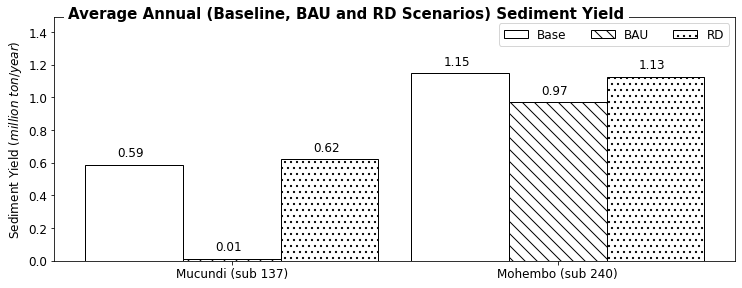

In [34]:
fig, ax = plt.subplots( 
                # sharex=True,
                figsize=(10,4)
                )

_X = np.arange(len(asbase.index))


ax.bar(_X-0.3, asbase, 0.3, label='Base', hatch='', color='white', edgecolor='black')
ax.bar(_X, asbau_df, 0.3, label='BAU', hatch='\\\\', color='white', edgecolor='black')
ax.bar(_X+0.3, asrd_df, 0.3, label='RD', hatch='..', color='white', edgecolor='black')

plt.xticks(_X, ['Mucundi (sub 137)', 'Mohembo (sub 240)']) # set labels manually
# x = date2num(df_base_as.index)
# w = 100
# ax.bar(x-50, df_base_as_.sub_240, width=w, align='center', label='Base')
# ax.bar(x+50, scn_df_as_.str_sim, width=w, align='center', label='BAU')
for index, value in zip(_X-0.35, asbase):
    ax.text(index, value+0.05, '{:1.2f}'.format(value), fontsize=12)
for index, value in zip(_X-0.05, asbau_df):
    ax.text(index, value+0.05, '{:1.2f}'.format(value), fontsize=12)
for index, value in zip(_X+0.25, asrd_df):
    ax.text(index, value+0.05, '{:1.2f}'.format(value), fontsize=12)
# ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
ax.tick_params(axis='both', labelsize=12)
# # plt.setp(ax.get_xticklabels(), rotation=70)
# ax.set_xticks(x[::1])
# ax.xaxis_date()
# # plt.xticks[1].set_visible(False)

ax.margins(y=0.3)
ax.set_title(
    'Average Annual (Baseline, BAU and RD Scenarios) Sediment Yield',
    fontsize=15,
    fontweight="bold",
    horizontalalignment='left',
    x=0.02,
    y=0.97,
    bbox=dict(
        facecolor='white',
        edgecolor='white'))
# ax.autoscale(tight=True)
# ax.text(-0.005, 1.01, '1e6', fontsize=8, transform=ax.transAxes)
plt.tight_layout()
ax.legend(fontsize=12, ncol=3)
# ax.grid(axis='y')
ax.set_ylabel(r'Sediment Yield $(million\ ton/year)$', fontsize = 12)
plt.savefig('aat_okvgfff.png', dpi=300, bbox_inches="tight")
plt.show()

In [16]:
os.getcwd()

'd:\\spark-brc_gits\\swatmf_git'

In [73]:
(1.15-1.13)

0.020000000000000018

In [12]:
os.getcwd()

'd:\\spark-brc_gits\\swatmf_git'

# Create Dataframe from output.sub

## 1. Base

In [74]:
colnum = 13
colnam = 'SYLDt/ha'
ylabel = "Sediment Yield (tons/ha)"


In [146]:
# Select subs
subs = [137, 240]

# Create data with parameter change
df_sub = pd.read_csv(
                    os.path.join(wd_base, "output.sub"),
                    delim_whitespace=True,
                    skiprows=9,
                    usecols=[1, 3, colnum],
                    names=["date", "filter", colnam],
                    index_col=0,
                    dtype={'filter': str})

df_adj = pd.DataFrame()
for i in subs:
    df = df_sub.loc[i]
    df = df[df["filter"].astype(str).map(len) < 13]

    df.index = pd.date_range('1/1/2003', periods=len(df[colnam]), freq="M")
    df.rename(columns = {colnam:'base_{}'.format(i)}, inplace = True)
    df_adj = pd.concat(
        [df_adj, df['base_{}'.format(i)]], axis=1,
        sort=False
        )
df_adj.index = pd.DatetimeIndex(df_adj.index).normalize()

In [147]:
df_adj

,base_137,base_240
2003-01-31,0.031,0.027
2003-02-28,0.554,0.029
2003-03-31,0.002,0.005
2003-04-30,0.005,0.005
2003-05-31,0.000,0.000
...,...,...
2019-08-31,0.000,0.000
2019-09-30,0.000,0.000
2019-10-31,0.000,0.000
2019-11-30,0.000,0.000


## 2. BAU

In [148]:
# Select subs
subs = [137, 240]

# Create data with parameter change
df_sub = pd.read_csv(
                    os.path.join(wd_scn, "output.sub"),
                    delim_whitespace=True,
                    skiprows=9,
                    usecols=[1, 3, colnum],
                    names=["date", "filter", colnam],
                    dtype = {'filter': str},
                    index_col=0)

df_scn = pd.DataFrame()
for i in subs:
    df = df_sub.loc[i]
    df = df[df["filter"].astype(str).map(len) < 13]
    df.index = pd.date_range('1/1/2003', periods=len(df[colnam]), freq="M")
    df.rename(columns = {colnam:'scn_{}'.format(i)}, inplace = True)
    df_scn = pd.concat(
        [df_scn, df['scn_{}'.format(i)]], axis=1,
        sort=False
        )
df_scn.index = pd.DatetimeIndex(df_scn.index).normalize()
scn_df = df_scn

In [149]:
df_scn = df_scn.groupby(df_scn.index.month).mean()
df_scn

,scn_137,scn_240
1,2.485882,0.077647
2,4.445059,0.109647
3,1.924471,0.156824
4,0.198588,0.011471
5,0.000000,0.000000
6,0.000000,0.000000
7,0.000000,0.000000
8,0.000000,0.000000
9,0.000000,0.000000
10,0.000000,0.000000


# 3. RD

In [151]:
# Select subs
subs = [137, 240]

# Create data with parameter change
df_sub = pd.read_csv(
                    os.path.join(wd_rd, "output.sub"),
                    delim_whitespace=True,
                    skiprows=9,
                    usecols=[1, 3, colnum],
                    names=["date", "filter", colnam],
                    dtype = {'filter': str},
                    index_col=0)

df_rd = pd.DataFrame()
for i in subs:
    df = df_sub.loc[i]
    df = df[df["filter"].astype(str).map(len) < 13]
    df.index = pd.date_range('1/1/2003', periods=len(df[colnam]), freq="M")
    df.rename(columns = {colnam:'rd_{}'.format(i)}, inplace = True)
    df_rd = pd.concat(
        [df_rd, df['rd_{}'.format(i)]], axis=1,
        sort=False
        )
df_rd.index = pd.DatetimeIndex(df_rd.index).normalize()
rd_df = df_rd

In [152]:
df_rd = df_rd.groupby(df_rd.index.month).mean()
df_rd

,rd_137,rd_240
1,1.514353,0.058765
2,2.787765,0.087588
3,1.125412,0.107412
4,0.103941,0.005882
5,0.000000,0.000000
6,0.000000,0.000000
7,0.000000,0.000000
8,0.000000,0.000000
9,0.000000,0.000000
10,0.000000,0.000000


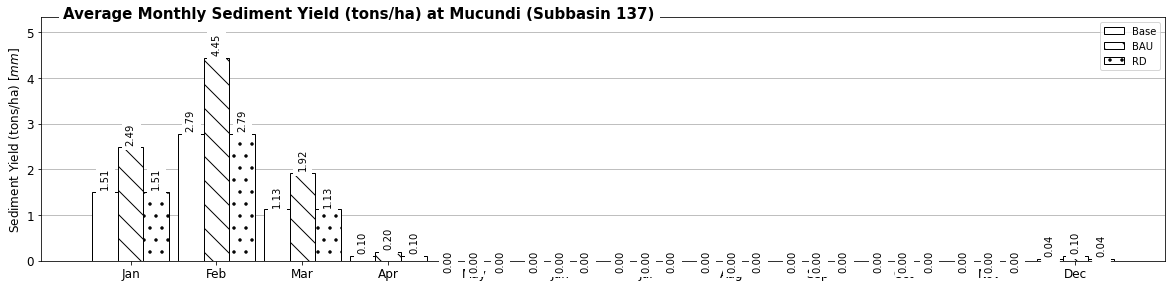

In [137]:
fig, ax = plt.subplots( 
                # sharex=True,
                figsize=(16,4)
                )
# x = date2num(base_df.index)
w = 0.3
ax.bar(base_df.index-0.3, base_df.base_137, width=w, align='center', label='Base', hatch='', color='white', edgecolor='black', zorder=3)
ax.bar(base_df.index, df_scn.scn_137, width=w, align='center', label='BAU', hatch='\\', color='white', edgecolor='black', zorder=3)
ax.bar(base_df.index+0.3, df_rd.rd_137, width=w, align='center', label='RD', hatch='.', color='white', edgecolor='black', zorder=3)

for index, value in zip(base_df.index-0.2, base_df.base_137):
    if value > 0:
        ax.text(
            index-0.1, value+0.05, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white',
            horizontalalignment='center'
            )
    else:
        ax.text(
            index-0.1, value-0.25, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white',
            horizontalalignment='center'
            )
for index, value in zip(base_df.index, df_scn.scn_137):
    if value > 0:
        ax.text(
            index, value+0.05, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white',
            horizontalalignment='center'            
            )
    else:
        ax.text(
            index, value-0.25, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white',
            horizontalalignment='center'                       
            )
for index, value in zip(base_df.index, df_rd.rd_137):
    if value > 0:
        ax.text(
            index+0.3, value+0.05, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white', 
            horizontalalignment='center'           
            )
    else:
        ax.text(
            index+0.3, value-0.25, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white',
            horizontalalignment='center'            
            )

ax.tick_params(axis='both', labelsize=12)
# plt.setp(ax.get_xticklabels(), rotation=70)
# ax.set_xticks(base_df.index[::1])
# ax.xaxis_date()
# plt.xticks[1].set_visible(False)
ax.set_xticks(base_df.index[::1])
month_names = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_xticklabels(month_names)
ax.margins(y=0.2)
ax.set_title(
    'Average Monthly {} at Mucundi (Subbasin 137)'.format(ylabel),
    fontsize=15,
    fontweight="bold",
    horizontalalignment='left',
    x=0.02,
    y=0.97,
    bbox=dict(
        facecolor='white',
        edgecolor='white'))
# ax.autoscale(tight=True)
plt.tight_layout()
ax.legend(fontsize=10)
ax.grid(axis='y', zorder=0)
ax.set_ylabel('{} $[mm]$'.format(ylabel), fontsize = 12)
plt.savefig('am_mucundi_{}.png'.format('dd'), dpi=300, bbox_inches="tight")
plt.show()

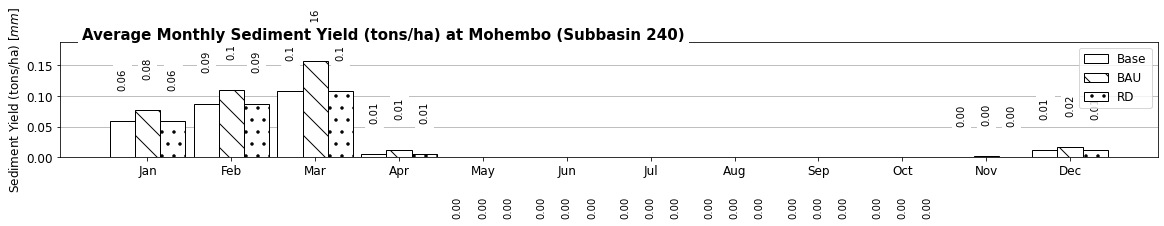

In [138]:
fig, ax = plt.subplots( 
                # sharex=True,
                figsize=(16,4)
                )
# x = date2num(base_df.index)
w = 0.3
ax.bar(base_df.index-0.3, base_df.base_240, width=w, align='center', label='Base', hatch='', color='white', edgecolor='black', zorder=3)
ax.bar(base_df.index, df_scn.scn_240, width=w, align='center', label='BAU', hatch='\\', color='white', edgecolor='black', zorder=3)
ax.bar(base_df.index+0.3, df_rd.rd_240, width=w, align='center', label='RD', hatch='.', color='white', edgecolor='black', zorder=3)


for index, value in zip(base_df.index-0.2, base_df.base_240):
    if value > 0:
        ax.text(
            index-0.1, value+0.05, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white',
            horizontalalignment='center'
            )
    else:
        ax.text(
            index-0.1, value-0.1, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white',
            horizontalalignment='center'
            )
for index, value in zip(base_df.index, df_scn.scn_240):
    if value > 0:
        ax.text(
            index, value+0.05, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white',
            horizontalalignment='center'            
            )
    else:
        ax.text(
            index, value-0.1, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white',
            horizontalalignment='center'                       
            )
for index, value in zip(base_df.index, df_rd.rd_240):
    if value > 0:
        ax.text(
            index+0.3, value+0.05, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white', 
            horizontalalignment='center'           
            )
    else:
        ax.text(
            index+0.3, value-0.1, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white',
            horizontalalignment='center'            
            )


ax.tick_params(axis='both', labelsize=12)
# plt.setp(ax.get_xticklabels(), rotation=70)
# ax.set_xticks(base_df.index[::1])
# ax.xaxis_date()
# plt.xticks[1].set_visible(False)
ax.set_xticks(base_df.index[::1])
month_names = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_xticklabels(month_names)


ax.margins(y=0.2)
ax.set_title(
    'Average Monthly {} at Mohembo (Subbasin 240)'.format(ylabel),
    fontsize=15,
    fontweight="bold",
    horizontalalignment='left',
    x=0.02,
    y=0.97,
    bbox=dict(
        facecolor='white',
        edgecolor='white'))
# ax.autoscale(tight=True)
plt.tight_layout()
ax.legend(fontsize=12)
ax.grid(axis='y', zorder=0)
ax.set_ylabel('{} $[mm]$'.format(ylabel), fontsize = 12)
plt.savefig('am_mohembo_{}.png'.format('dd'), dpi=300, bbox_inches="tight")
plt.show()

# Annual Total sedi

In [139]:
df_adj

,base_137,base_240
2003-01-31,0.031,0.027
2003-02-28,0.554,0.029
2003-03-31,0.002,0.005
2003-04-30,0.005,0.005
2003-05-31,0.000,0.000
...,...,...
2019-08-31,0.000,0.000
2019-09-30,0.000,0.000
2019-10-31,0.000,0.000
2019-11-30,0.000,0.000


In [154]:
asbase_sub = df_adj.resample('A').sum().mean()
asbase_sub

base_137    5.571235
base_240    0.272353
dtype: float64

In [155]:
asbau_sub = scn_df.resample('A').sum().mean()
asbau_sub

scn_137    9.156824
scn_240    0.374059
dtype: float64

In [156]:
asrd_sub = rd_df.resample('A').sum().mean()
asrd_sub



rd_137    5.571235
rd_240    0.272353
dtype: float64

In [17]:
fig, ax = plt.subplots( 
                # sharex=True,
                figsize=(10,4)
                )

_X = np.arange(len(asbase_sub.index))


ax.bar(_X-0.3, asbase_sub, 0.3, label='Base', hatch='', color='white', edgecolor='black')
ax.bar(_X, asbau_sub, 0.3, label='BAU', hatch='\\', color='white', edgecolor='black')
ax.bar(_X+0.3, asrd_sub, 0.3, label='RD', hatch='.', color='white', edgecolor='black')

plt.xticks(_X, ['Mucundi (sub 137)', 'Mohembo (sub 240)']) # set labels manually
# x = date2num(df_base_as.index)
# w = 100
# ax.bar(x-50, df_base_as_.sub_240, width=w, align='center', label='Base')
# ax.bar(x+50, scn_df_as_.str_sim, width=w, align='center', label='BAU')
for index, value in zip(_X-0.35, asbase_sub):
    ax.text(index, value+0.05, '{:1.2f}'.format(value), fontsize=12)
for index, value in zip(_X-0.05, asbau_sub):
    ax.text(index, value+0.05, '{:1.2f}'.format(value), fontsize=12)
for index, value in zip(_X+0.25, asrd_sub):
    ax.text(index, value+0.05, '{:1.2f}'.format(value), fontsize=12)
# ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
ax.tick_params(axis='both', labelsize=12)
# # plt.setp(ax.get_xticklabels(), rotation=70)
# ax.set_xticks(x[::1])
# ax.xaxis_date()
# # plt.xticks[1].set_visible(False)

ax.margins(y=0.3)
ax.set_title(
    'Average Annual Total (Base and BAU) Sediment Yield',
    fontsize=15,
    fontweight="bold",
    horizontalalignment='left',
    x=0.05,
    y=0.97,
    bbox=dict(
        facecolor='white',
        edgecolor='white'))
# ax.autoscale(tight=True)
# ax.text(-0.005, 1.01, '1e6', fontsize=8, transform=ax.transAxes)
plt.tight_layout()
ax.legend(fontsize=12)
# ax.grid(axis='y')
ax.set_ylabel(r'Sediment Yield (million $ton/year$)', fontsize = 12)
# plt.savefig('aat_okvg_sub.png', dpi=300, bbox_inches="tight")
plt.show()

NameError: name 'asbase_sub' is not defined